In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [38]:
def load_and_explore_data(file_path):
    """
    Charge et explore les données initiales
    """
    df = pd.read_csv(file_path)

    print(f"Shape du dataset : {df.shape}")
    print(f"Colonnes : {list(df.columns)}")
    print(df.dtypes)
    
    print("\n=== VALEURS MANQUANTES ===")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valeurs_manquantes': missing_values,
        'Pourcentage': missing_percent
    })
    print(missing_df[missing_df['Valeurs_manquantes'] > 0])
    
    print("\n=== STATISTIQUES DESCRIPTIVES ===")
    print(df.describe())
    
    return df

In [39]:
def clean_data(df):
    """
    Nettoyage et gestion des valeurs manquantes
    """
    df_clean = df.copy()

    if 'date' in df_clean.columns:
        df_clean['date'] = pd.to_datetime(df_clean['date'])
        
        # Extraction de features temporelles
        df_clean['year'] = df_clean['date'].dt.year
        df_clean['month'] = df_clean['date'].dt.month
        df_clean['quarter'] = df_clean['date'].dt.quarter
    
    # Gestion des valeurs manquantes
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    
    # Pour les colonnes numériques : imputation par médiane
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"Valeurs manquantes dans {col} remplacées par médiane: {median_val}")
    
    # Pour les colonnes catégorielles : imputation par mode
    for col in categorical_cols:
        if col != 'date' and df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"Valeurs manquantes dans {col} remplacées par mode: {mode_val}")
    
    return df_clean

In [40]:
def feature_engineering(df):
    """
    Création de nouvelles variables avec gestion des valeurs infinies
    """
    df_features = df.copy()
    
    # Age de la maison
    current_year = datetime.now().year
    df_features['house_age'] = current_year - df_features['yr_built']
    
    # Indicateur de rénovation
    df_features['is_renovated'] = (df_features['yr_renovated'] > 0).astype(int)
    
    # Age depuis rénovation (si rénovée)
    df_features['years_since_renovation'] = np.where(
        df_features['yr_renovated'] > 0,
        current_year - df_features['yr_renovated'],
        df_features['house_age']
    )
    
    # Ratio surface habitable / terrain (avec protection contre division par zéro)
    df_features['living_lot_ratio'] = df_features['sqft_living'] / np.maximum(df_features['sqft_lot'], 1)
    
    # Surface moyenne par pièce (avec protection contre division par zéro)
    df_features['sqft_per_bedroom'] = df_features['sqft_living'] / np.maximum(df_features['bedrooms'], 1)
    df_features['sqft_per_bathroom'] = df_features['sqft_living'] / np.maximum(df_features['bathrooms'], 1)
    
    # Indicateur de sous-sol
    df_features['has_basement'] = (df_features['sqft_basement'] > 0).astype(int)
    
    # Ratio sous-sol / surface totale (avec protection contre division par zéro)
    df_features['basement_ratio'] = df_features['sqft_basement'] / np.maximum(df_features['sqft_living'], 1)
    
    # Prix au m² (si on a le prix pour l'entraînement)
    if 'price' in df_features.columns:
        df_features['price_per_sqft'] = df_features['price'] / np.maximum(df_features['sqft_living'], 1)
    
    # Variables catégorielles ordinales
    condition_mapping = {1: 'Poor', 2: 'Fair', 3: 'Average', 4: 'Good', 5: 'Very Good'}
    df_features['condition_label'] = df_features['condition'].map(condition_mapping)
    
    # Extraction d'informations géographiques
    if 'statezip' in df_features.columns:
        df_features['state'] = df_features['statezip'].str[:2]
        df_features['zipcode'] = df_features['statezip'].str[3:]
    
    # ÉTAPE CRUCIALE : Nettoyage des valeurs infinies et très grandes
    print("\n=== NETTOYAGE DES VALEURS INFINIES ===")
    
    # Remplacer les valeurs infinies par NaN
    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Vérifier et afficher les colonnes avec des NaN après remplacement
    nan_cols = df_features.isnull().sum()
    print("Colonnes avec des NaN après nettoyage des inf:")
    print(nan_cols[nan_cols > 0])
    
    # Traiter les NaN créés par le remplacement des inf
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_features[col].isnull().sum() > 0:
            # Utiliser la médiane pour remplacer les NaN
            median_val = df_features[col].median()
            df_features[col].fillna(median_val, inplace=True)
            print(f"NaN dans {col} remplacés par médiane: {median_val}")
    
    # Vérification finale des valeurs extrêmes
    print("\n=== VÉRIFICATION DES VALEURS EXTRÊMES ===")
    for col in numeric_cols:
        col_max = df_features[col].max()
        col_min = df_features[col].min()
        
        # Cap des valeurs très grandes (plus de 1e10)
        if col_max > 1e10:
            percentile_99 = df_features[col].quantile(0.99)
            df_features[col] = np.where(
                df_features[col] > percentile_99 * 10,
                percentile_99,
                df_features[col]
            )
            print(f"Valeurs extrêmes dans {col} plafonnées à {percentile_99}")
        
        # Vérifier les valeurs négatives inappropriées
        if col in ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms'] and col_min < 0:
            df_features[col] = np.maximum(df_features[col], 0)
            print(f"Valeurs négatives dans {col} remplacées par 0")
    
    print("\n=== NOUVELLES FEATURES CRÉÉES ===")
    new_features = ['house_age', 'is_renovated', 'years_since_renovation', 
                   'living_lot_ratio', 'sqft_per_bedroom', 'sqft_per_bathroom',
                   'has_basement', 'basement_ratio', 'condition_label', 'state', 'zipcode']
    for feature in new_features:
        if feature in df_features.columns:
            print(f"✓ {feature}")
    
    return df_features

In [41]:
def create_visualizations(df):
    """
    Crée des visualisations pour l'analyse exploratoire
    """
    plt.style.use('default')  # Changé car seaborn-v0_8 peut ne pas exister
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Distribution des prix
    axes[0, 0].hist(df['price'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution des prix')
    axes[0, 0].set_xlabel('Prix')
    axes[0, 0].set_ylabel('Fréquence')
    
    # Prix vs superficie habitable
    axes[0, 1].scatter(df['sqft_living'], df['price'], alpha=0.5, color='orange')
    axes[0, 1].set_title('Prix vs Surface habitable')
    axes[0, 1].set_xlabel('Surface habitable (sqft)')
    axes[0, 1].set_ylabel('Prix')
    
    # Prix par nombre de chambres
    df.boxplot(column='price', by='bedrooms', ax=axes[0, 2])
    axes[0, 2].set_title('Prix par nombre de chambres')
    
    # Prix par condition
    df.boxplot(column='price', by='condition', ax=axes[1, 0])
    axes[1, 0].set_title('Prix par condition')
    
    # Corrélation avec le prix
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()['price'].sort_values(ascending=False)
    
    axes[1, 1].barh(range(len(correlations[:10])), correlations[:10].values)
    axes[1, 1].set_yticks(range(len(correlations[:10])))
    axes[1, 1].set_yticklabels(correlations[:10].index)
    axes[1, 1].set_title('Top 10 corrélations avec le prix')
    
    # Heatmap des corrélations principales
    main_features = ['price', 'sqft_living', 'sqft_above', 'sqft_basement', 
                    'bedrooms', 'bathrooms', 'floors', 'yr_built']
    # Vérifier que ces colonnes existent
    main_features = [f for f in main_features if f in df.columns]
    corr_matrix = df[main_features].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Matrice de corrélation')
    
    plt.tight_layout()
    plt.show()
    
    return correlations

In [42]:
def detect_outliers(df, columns=None):
    """
    Détecte les outliers avec la méthode IQR
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    outliers_info = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_info[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    
    print("=== DÉTECTION D'OUTLIERS (méthode IQR) ===")
    for col, info in outliers_info.items():
        if info['count'] > 0:
            print(f"{col}: {info['count']} outliers ({info['percentage']:.2f}%)")
    
    return outliers_info

In [43]:
def validate_data_quality(df):
    """
    Validation finale de la qualité des données
    """
    print("\n=== VALIDATION FINALE DES DONNÉES ===")
    
    # Vérifier les valeurs infinies
    inf_check = np.isinf(df.select_dtypes(include=[np.number])).sum()
    print("Valeurs infinies par colonne:")
    print(inf_check[inf_check > 0])
    
    # Vérifier les NaN
    nan_check = df.isnull().sum()
    print("\nValeurs NaN par colonne:")
    print(nan_check[nan_check > 0])
    
    # Vérifier les valeurs très grandes
    print("\nStatistiques des valeurs maximales:")
    numeric_df = df.select_dtypes(include=[np.number])
    max_values = numeric_df.max().sort_values(ascending=False)
    print(max_values.head(10))
    
    # Vérifier que toutes les colonnes numériques sont dans une plage raisonnable
    problematic_cols = []
    for col in numeric_df.columns:
        if numeric_df[col].max() > 1e12:  # Valeurs extrêmement grandes
            problematic_cols.append(col)
    
    if problematic_cols:
        print(f"\n⚠️ ATTENTION: Colonnes avec des valeurs très grandes: {problematic_cols}")
    else:
        print("\n✅ Toutes les valeurs numériques sont dans des plages raisonnables")
    
    return len(problematic_cols) == 0

In [44]:
def main_preprocessing(file_path):
    """
    Pipeline complet de préprocessing avec validation
    """
    print("🚀 DÉMARRAGE DU PREPROCESSING")
    
    print("\n1. Chargement des données")
    df = load_and_explore_data(file_path)

    print("\n2. Nettoyage des données")
    df_clean = clean_data(df)
   
    print("\n3. Ingénierie de features")
    df_features = feature_engineering(df_clean)
    
    print("\n4. Validation de la qualité des données")
    is_valid = validate_data_quality(df_features)
    
    if not is_valid:
        print("❌ Problèmes détectés dans les données. Arrêt du processus.")
        return None, None, None

    print("\n5. Visualisations exploratoires")
    correlations = create_visualizations(df_features)
  
    print("\n6. Détection d'outliers")
    outliers_info = detect_outliers(df_features)

    # Sauvegarde
    output_file = file_path.replace('.csv', '_preprocessed.csv')
    df_features.to_csv(output_file, index=False)
    print(f"\n✅ Données préprocessées sauvegardées: {output_file}")
    
    return df_features, correlations, outliers_info

🚀 DÉMARRAGE DU PREPROCESSING

1. Chargement des données
Shape du dataset : (4600, 18)
Colonnes : ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

=== VALEURS MANQUANTES ===
Empty DataFrame
Columns: [Valeurs_manquantes, Pourcentage]
Index: []

=== STATISTIQUES DESCRIPTIVES ===
              price     bedrooms    bathrooms   sqft_living      sqft_lot  \
count  4.600000

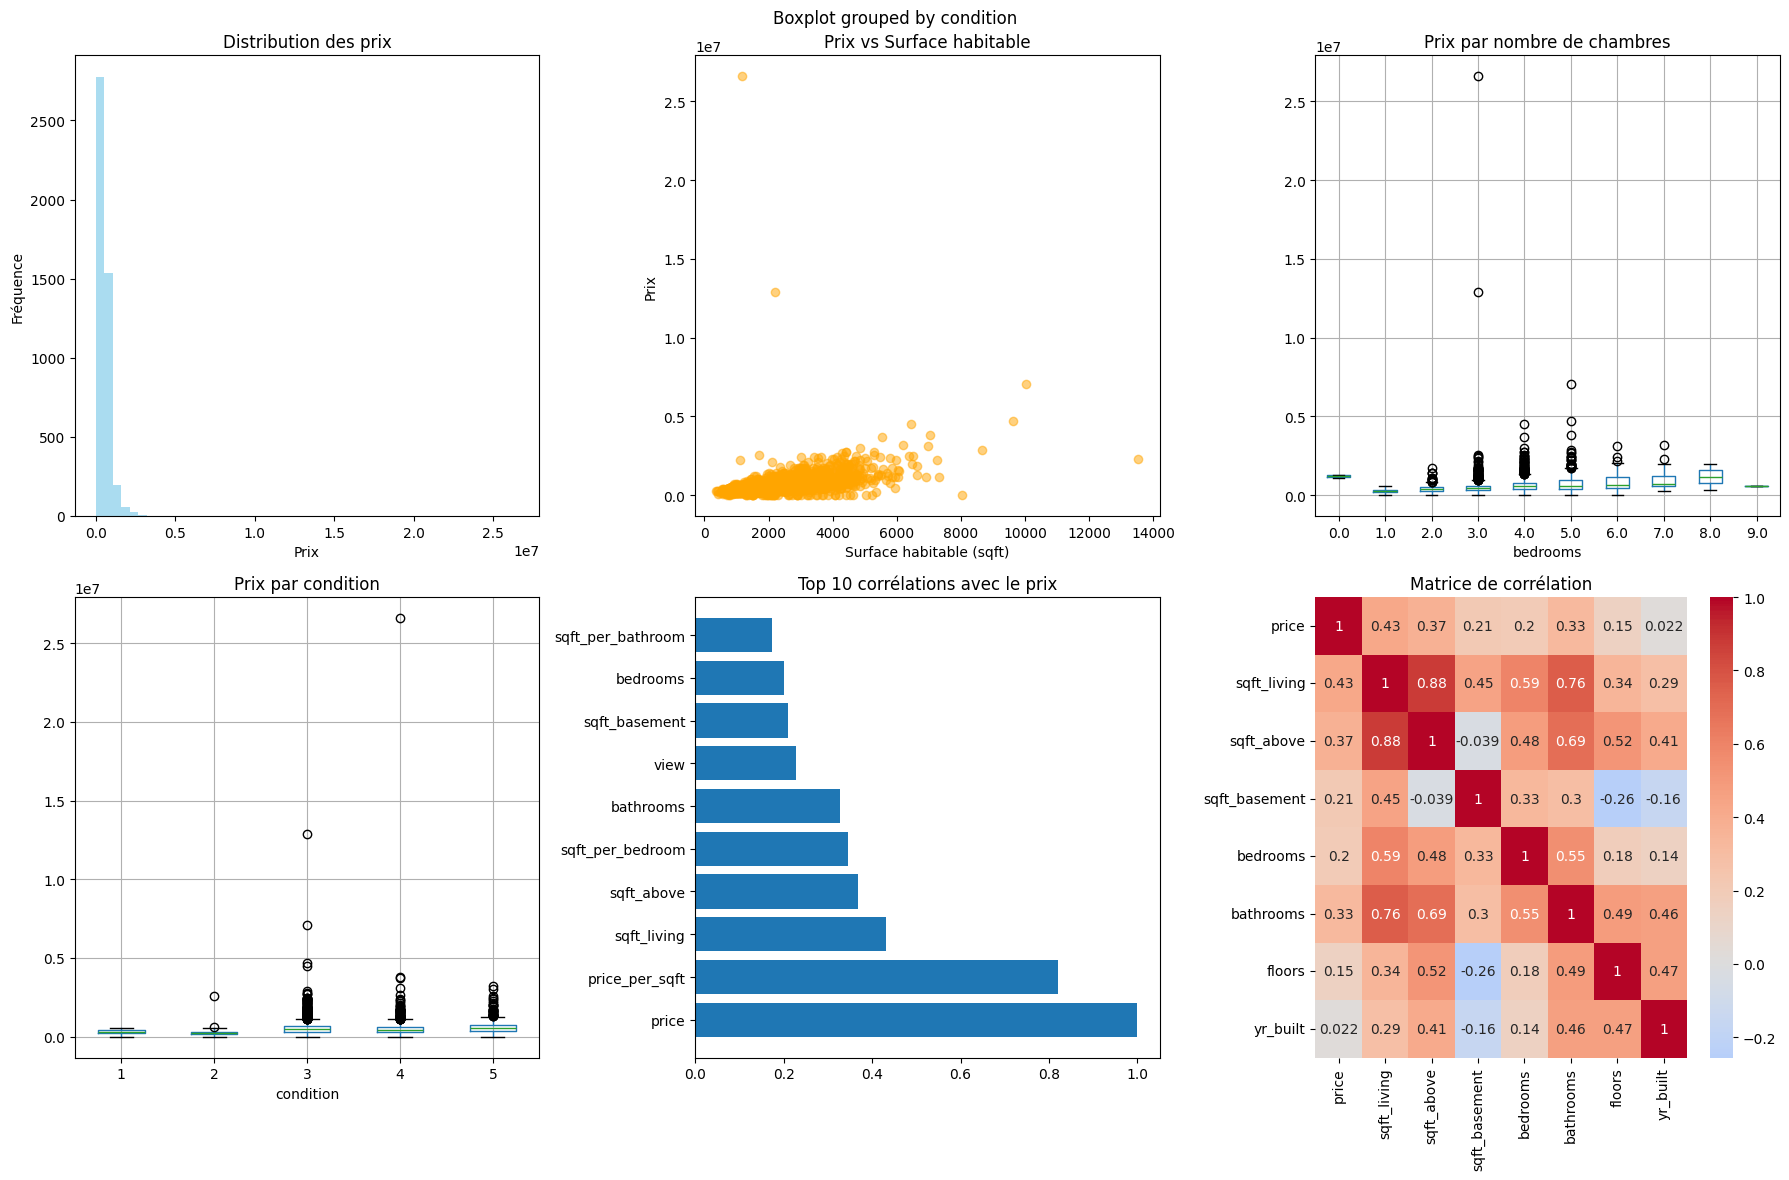


6. Détection d'outliers
=== DÉTECTION D'OUTLIERS (méthode IQR) ===
price: 240 outliers (5.22%)
bedrooms: 118 outliers (2.57%)
bathrooms: 141 outliers (3.07%)
sqft_living: 129 outliers (2.80%)
sqft_lot: 541 outliers (11.76%)
waterfront: 33 outliers (0.72%)
view: 460 outliers (10.00%)
condition: 6 outliers (0.13%)
sqft_above: 116 outliers (2.52%)
sqft_basement: 82 outliers (1.78%)
quarter: 653 outliers (14.20%)
years_since_renovation: 282 outliers (6.13%)
living_lot_ratio: 288 outliers (6.26%)
sqft_per_bedroom: 146 outliers (3.17%)
sqft_per_bathroom: 123 outliers (2.67%)
price_per_sqft: 134 outliers (2.91%)

✅ Données préprocessées sauvegardées: ../data/data_preprocessed.csv


In [46]:
if __name__ == "__main__":
    file_path = "../data/data.csv"
    df_processed, correlations, outliers = main_preprocessing(file_path)


In [47]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/data_preprocessed.csv")

# Vérifier les valeurs infinies
print(np.isinf(df.select_dtypes(include=[np.number])).sum().sort_values(ascending=False))

# Vérifier les NaN
print(df.isnull().sum().sort_values(ascending=False))

# Vérifier les valeurs très grandes
print(df.describe().T.sort_values("max", ascending=False).head(10))


price                     0
bedrooms                  0
bathrooms                 0
sqft_living               0
sqft_lot                  0
floors                    0
waterfront                0
view                      0
condition                 0
sqft_above                0
sqft_basement             0
yr_built                  0
yr_renovated              0
year                      0
month                     0
quarter                   0
house_age                 0
is_renovated              0
years_since_renovation    0
living_lot_ratio          0
sqft_per_bedroom          0
sqft_per_bathroom         0
has_basement              0
basement_ratio            0
price_per_sqft            0
zipcode                   0
dtype: int64
date                      0
price                     0
bedrooms                  0
bathrooms                 0
sqft_living               0
sqft_lot                  0
floors                    0
waterfront                0
view                      0
conditi